In [ ]:
import os

import numpy as np
import pandas as pd

import datetime
import math

import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change filepath
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone/simulated-data')

In [ ]:
cust_orig = pd.read_csv('profile_customer.csv')
term_orig = pd.read_csv('profile_terminal.csv')
trans_orig = pd.read_csv('trans.csv')
display(cust_orig.info())
display(term_orig.info())
display(trans_orig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CUSTOMER_ID          5000 non-null   int64  
 1   x_customer_id        5000 non-null   float64
 2   y_customer_id        5000 non-null   float64
 3   mean_amount          5000 non-null   float64
 4   std_amount           5000 non-null   float64
 5   mean_nb_tx_per_day   5000 non-null   float64
 6   available_terminals  5000 non-null   object 
 7   nb_terminals         5000 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TERMINAL_ID    2500 non-null   int64  
 1   x_terminal_id  2500 non-null   float64
 2   y_terminal_id  2500 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.7 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3579106 entries, 0 to 3579105
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   TRANSACTION_ID     int64  
 1   TX_DATETIME        object 
 2   CUSTOMER_ID        int64  
 3   TERMINAL_ID        int64  
 4   TX_AMOUNT          float64
 5   TX_TIME_SECONDS    int64  
 6   TX_TIME_DAYS       int64  
 7   TX_FRAUD           int64  
 8   TX_FRAUD_SCENARIO  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 245.8+ MB


None

In [ ]:
#change to datetime 
trans_orig.TX_DATETIME = pd.to_datetime(trans_orig.TX_DATETIME)

In [ ]:
trans_orig

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-01-01 00:00:00,42,1678,67.80,0,0,1,23
1,1,2018-01-01 00:00:00,1160,526,96.27,0,0,1,23
2,2,2018-01-01 00:00:00,4771,1006,56.49,0,0,1,23
3,3,2018-01-01 00:00:00,3866,443,60.71,0,0,1,23
4,4,2018-01-01 00:00:00,3367,1797,59.03,0,0,1,23
...,...,...,...,...,...,...,...,...,...
3579101,3579101,2019-01-13 02:25:02,747,1623,206.00,32581502,377,1,24
3579102,3579102,2019-01-13 02:31:25,909,442,141.00,32581885,377,1,24
3579103,3579103,2019-01-13 02:44:25,909,229,91.00,32582665,377,1,24
3579104,3579104,2019-01-13 18:51:47,2294,495,144.00,32640707,377,1,24


In [ ]:
print('No of customer in dataset:', trans_orig.CUSTOMER_ID.unique().shape[0])
print('No of compromised customer:', trans_orig[trans_orig.TX_FRAUD == 1].CUSTOMER_ID.unique().shape[0])
print('No of transactions in dataset:', trans_orig.shape[0])
display(trans_orig.groupby('TX_FRAUD').size())
print('% fraud:', 100 * trans_orig.TX_FRAUD.sum() / trans_orig.shape[0] , '%' )

No of customer in dataset: 4999
No of compromised customer: 4963
No of transactions in dataset: 3579106


TX_FRAUD
0    3519455
1      59651
dtype: int64

% fraud: 1.6666452460474768 %


In [ ]:
# # FOR DEBUGGING ONLY
# # Check number of fraud scenario
# display(trans_orig.groupby('TX_FRAUD_SCENARIO').TX_FRAUD.agg(['size']))
# display(trans_orig[(trans_orig.TX_FRAUD_SCENARIO == 22) & (trans_orig.TX_AMOUNT != 1)].shape[0])

In [ ]:
# trans_orig[(trans_orig.TX_AMOUNT < 1) & (trans_orig.TX_FRAUD != 1)]

In [ ]:
cust_orig

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals
0,0,75.752986,39.999407,10.259465,5.129733,2.574314,"[5, 10, 14, 17, 20, 24, 28, 30, 31, 38, 39, 41...",684
1,1,83.338141,18.607660,97.127791,48.563896,0.642323,"[14, 16, 20, 24, 38, 42, 44, 47, 50, 52, 60, 7...",491
2,2,23.087119,48.059291,19.428755,9.714378,0.500076,"[0, 3, 4, 5, 7, 8, 9, 10, 13, 19, 22, 26, 29, ...",640
3,3,64.502607,60.972675,19.838670,9.919335,2.639936,"[1, 2, 5, 6, 10, 11, 13, 14, 17, 21, 24, 25, 2...",734
4,4,79.055051,67.130143,5.787902,2.893951,3.937338,"[1, 2, 14, 17, 21, 25, 28, 30, 31, 36, 39, 41,...",662
...,...,...,...,...,...,...,...,...
4995,4995,87.273734,19.442874,39.988885,19.994443,2.696767,"[14, 20, 24, 38, 41, 42, 44, 47, 50, 52, 60, 7...",448
4996,4996,67.774671,7.354441,42.612407,21.306204,1.262838,"[16, 23, 24, 27, 38, 42, 47, 60, 66, 74, 82, 9...",469
4997,4997,28.112836,30.895884,75.153438,37.576719,3.425950,"[0, 4, 5, 7, 8, 9, 10, 15, 18, 19, 22, 23, 26,...",716
4998,4998,46.660083,4.945767,9.276711,4.638355,3.718668,"[0, 4, 7, 16, 22, 23, 27, 33, 40, 47, 54, 66, ...",443


In [ ]:
cust_orig.nb_terminals.mean()

539.0644

In [ ]:
trans_orig[trans_orig.TX_FRAUD == 0].TX_AMOUNT.agg(['mean','var'])

mean      53.840852
var     1570.530254
Name: TX_AMOUNT, dtype: float64


### Create a new "cust" dataframe similar to "cust_orig" with mean_amount, std_amount, mean_nb_tx_per_day calculated from geniune transactions.

In [ ]:
# Create cust
cust = trans_orig[trans_orig.TX_FRAUD == 0].groupby('CUSTOMER_ID').TX_AMOUNT.agg(['mean','std']).rename(columns = {'mean':'mean_amount','std':'std_amount'})
cust['mean_nb_tx_per_day'] = \
 trans_orig[trans_orig.TX_FRAUD == 0].groupby(['CUSTOMER_ID','TX_TIME_DAYS']).size().rename('cnt').reset_index().groupby('CUSTOMER_ID').cnt.mean()

cust = cust.reset_index()


### Create a new "trans" dataframe similar to "trans_orig" with customer having no genuine transaction removed, since z-score cannot be calculated for customer without any geniune transaction.

In [ ]:
# Create trans
trans = trans_orig.copy()
trans = trans.drop(trans[~trans.CUSTOMER_ID.isin(cust.CUSTOMER_ID)].index)
trans

# **EDA**

In [ ]:
#There are 3579099 rows and 9 columns
trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3579099 entries, 0 to 3579105
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        int64         
 3   TERMINAL_ID        int64         
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    int64         
 6   TX_TIME_DAYS       int64         
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 273.1 MB


In [ ]:
#There are no Nan/Null value
trans.isnull().sum()

TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

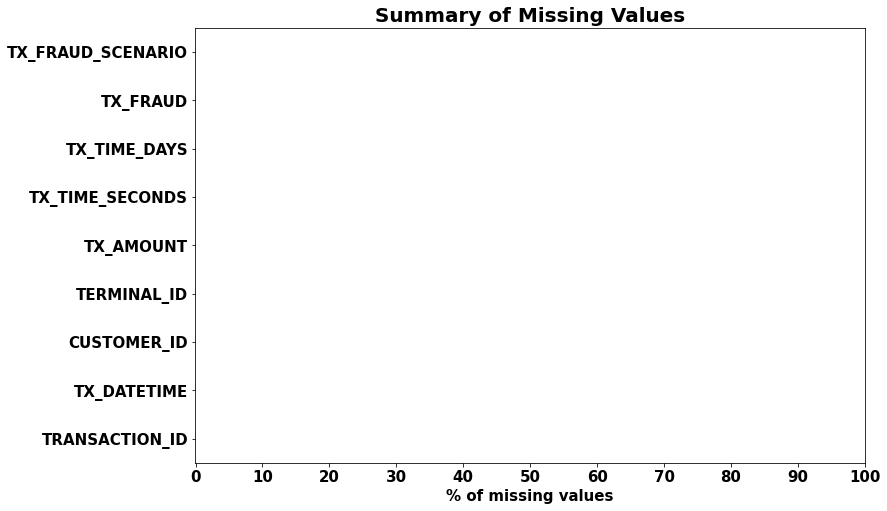

In [ ]:
#visual summart of % of missing value in each column
(trans.isna().sum() / trans.shape[0] * 100)\
    .sort_values()\
    .plot(kind='barh', figsize=(12,8))
plt.xticks(np.arange(0,110,10), fontsize=15, fontweight='bold')
plt.xlabel("% of missing values", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Summary of Missing Values", fontsize=20, fontweight='bold')
plt.show()

In [ ]:
#Create df only contain fraud and non fraud
df_fraud=trans[trans['TX_FRAUD']==1]

df_nonfraud=trans[trans['TX_FRAUD']==0]

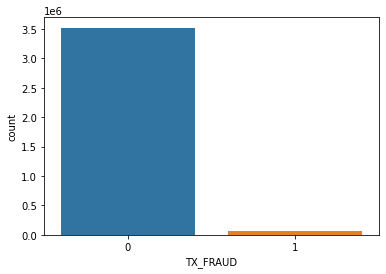

In [ ]:
# Genuine vs Fraud transaction count
_ = sns.countplot(data = trans, x = 'TX_FRAUD')

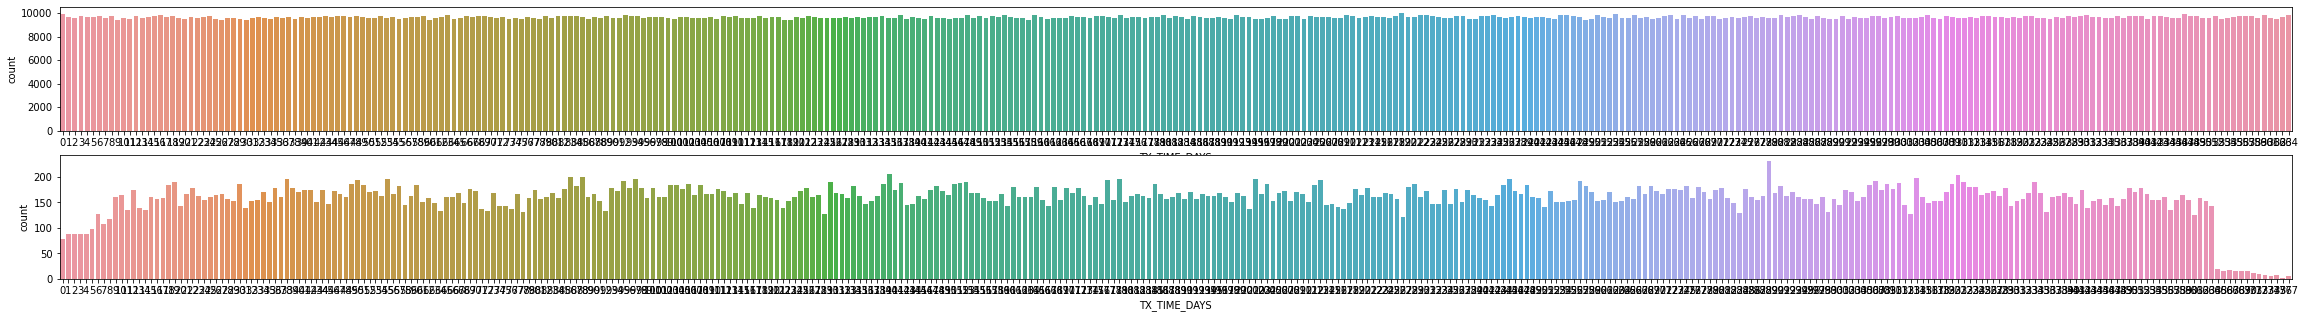

In [ ]:
# Geniune transactions per day
fig,axes = plt.subplots(2,1,figsize=(40,5))
_ = sns.countplot(data = trans[trans.TX_FRAUD == 0], x = 'TX_TIME_DAYS', ax = axes[0])
_ = sns.countplot(data = trans[trans.TX_FRAUD == 1], x = 'TX_TIME_DAYS', ax = axes[1])
## INSIGHT
## No obvious pattern observed

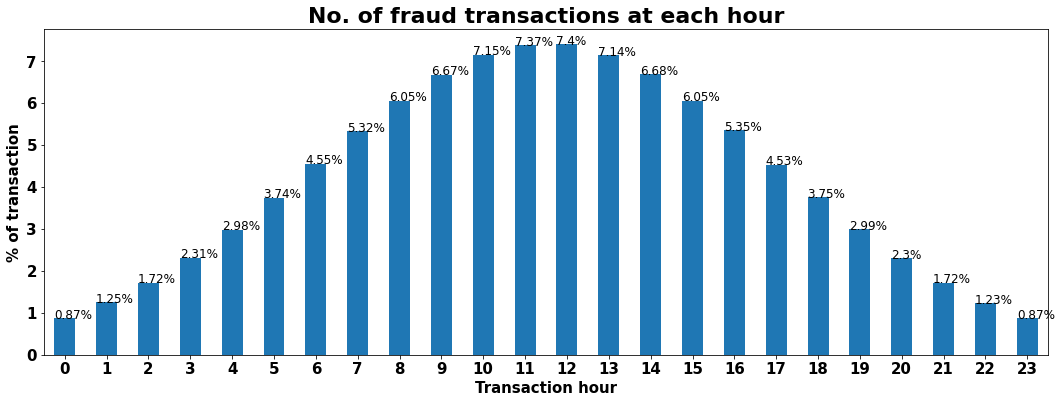

In [ ]:
# % of genuine transactions at each hour 
plt.figure(figsize=(18,6))
ax = (df_nonfraud.TX_DATETIME.dt.hour.value_counts(sort=False, normalize=True) * 100).round(2).plot(kind='bar')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)) + "%", fontsize=12, color='black')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% of transaction', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. of fraud transactions at each hour', fontsize=22, fontweight='bold')
plt.show()

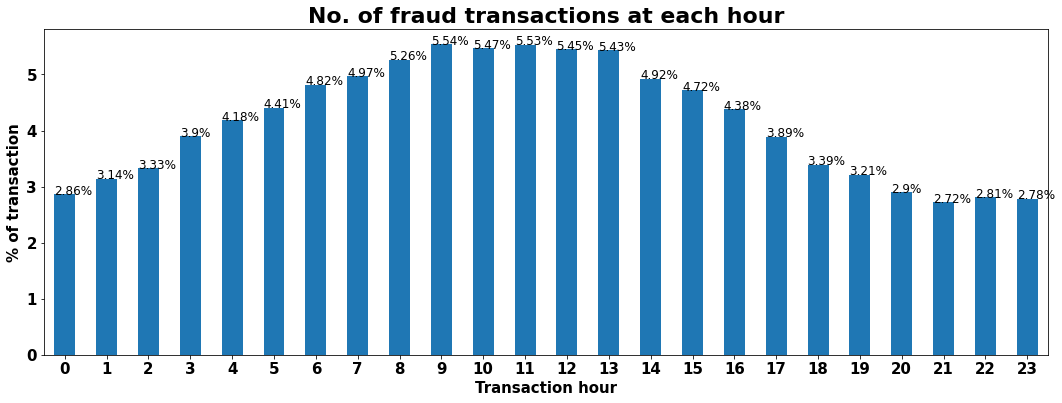

In [ ]:
# % of fraud transactions at each hour 
plt.figure(figsize=(18,6))
ax = (df_fraud.TX_DATETIME.dt.hour.value_counts(sort=False, normalize=True) * 100).round(2).plot(kind='bar')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)) + "%", fontsize=12, color='black')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% of transaction', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. of fraud transactions at each hour', fontsize=22, fontweight='bold')
plt.show()

From the above graphs, the distribution of fraudulent transaction is slightly from genuine transaction based on time of the day. 

#**1. The number of transactions, both fraud and genuine, peaks and valleys based on the time of the day.** (visualisation using Tableau)

**Fraudulent** transactions are more likely to occur during nighttime, particularly from 21:00 to 03:00 while **genuine** transaction are more likely to occur during daytime, usually peak at 12.


Bar chart below represent the no. of fraud transaction while yellow line represent percentage of fraud transaction over total no of transaction.


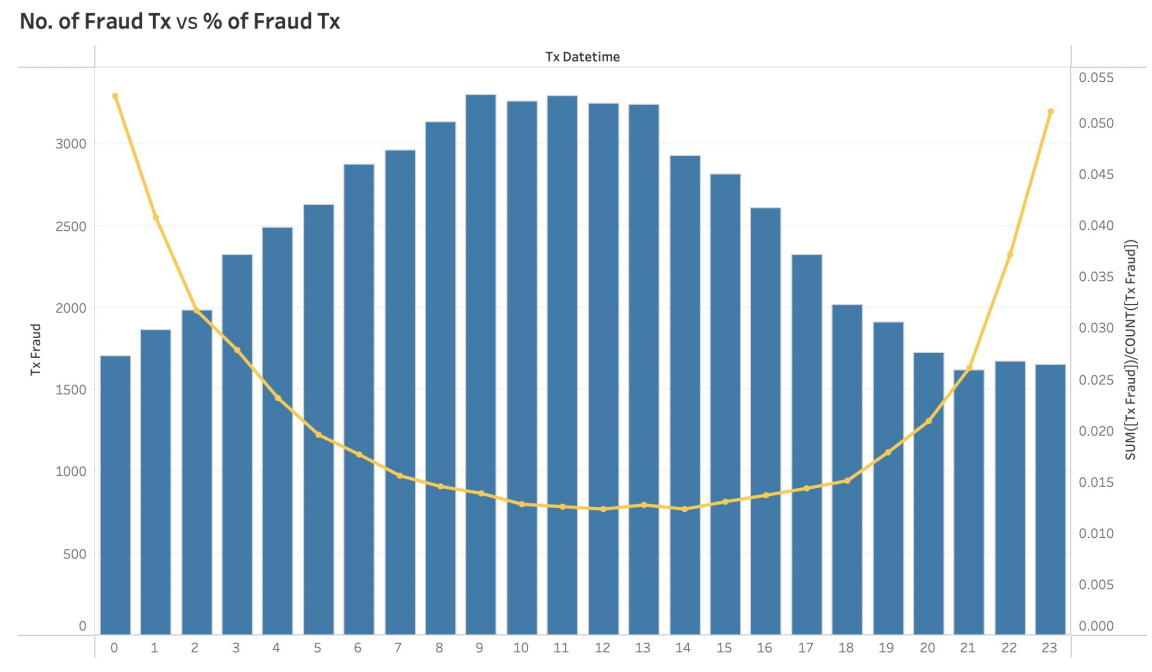

#**2. There is no difference between fraud and genuine transaction by day of a week.**

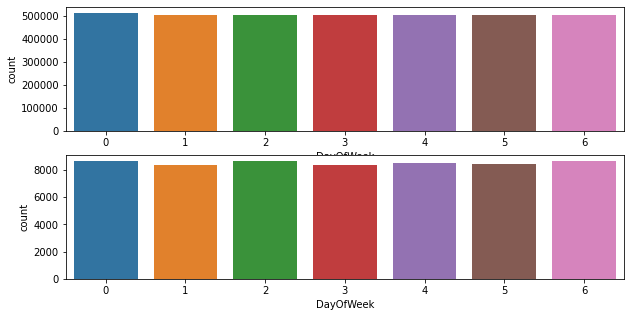

In [ ]:
# Geniune vs Fraudulent transactions by day of week
fig,axes = plt.subplots(2,1,figsize=(10,5))
_ = sns.countplot(data = trans[trans.TX_FRAUD == 0].assign(DayOfWeek = trans[trans.TX_FRAUD == 0].TX_DATETIME.dt.dayofweek), x = 'DayOfWeek', ax = axes[0])
_ = sns.countplot(data = trans[trans.TX_FRAUD == 1].assign(DayOfWeek = trans[trans.TX_FRAUD == 1].TX_DATETIME.dt.dayofweek), x = 'DayOfWeek', ax = axes[1])

# **3.Fraud transaction amount has larger range than that of genuine transaction.**

Fraud transaction amount falls in $0-$500 while genuine transaction amount falls in $0-$200 in this dataset.

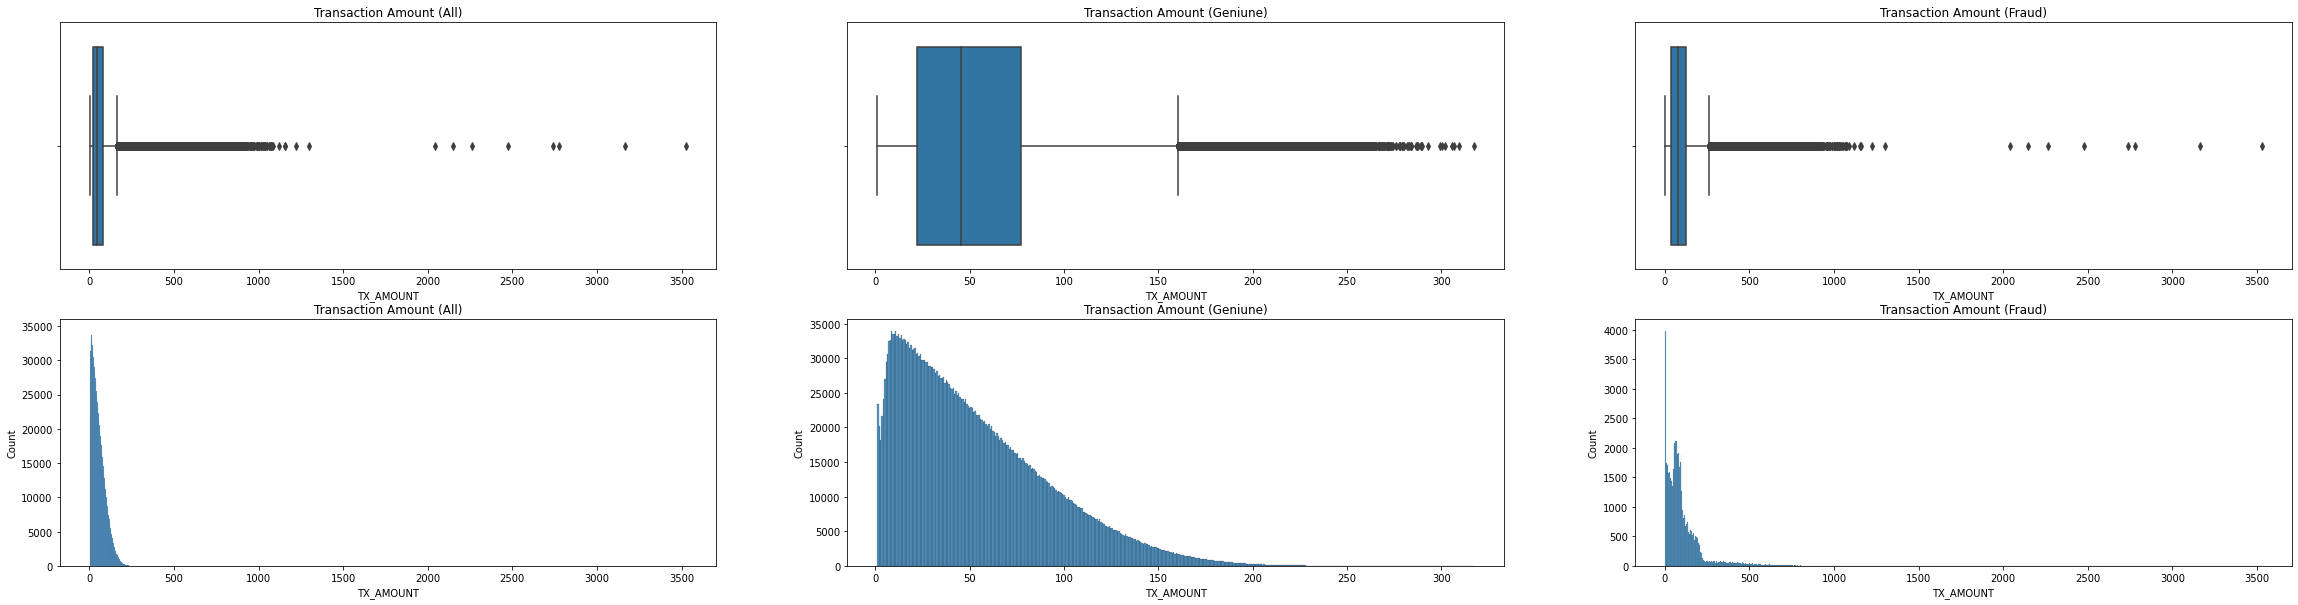

In [ ]:
# Transaction Amount
fig, axes = plt.subplots(2, 3, figsize=(40,10))
_ = sns.boxplot(data = trans, x = 'TX_AMOUNT', ax = axes[0][0]).set_title('Transaction Amount (All)')
_ = sns.boxplot(data = trans[trans.TX_FRAUD == 0], x = 'TX_AMOUNT', ax = axes[0][1]).set_title('Transaction Amount (Geniune)')
_ = sns.boxplot(data = trans[trans.TX_FRAUD == 1], x = 'TX_AMOUNT', ax = axes[0][2]).set_title('Transaction Amount (Fraud)')
_ = sns.histplot(data = trans, x = 'TX_AMOUNT', ax = axes[1][0]).set_title('Transaction Amount (All)')
_ = sns.histplot(data = trans[trans.TX_FRAUD == 0], x = 'TX_AMOUNT', ax = axes[1][1]).set_title('Transaction Amount (Geniune)')
_ = sns.histplot(data = trans[trans.TX_FRAUD == 1], x = 'TX_AMOUNT', ax = axes[1][2]).set_title('Transaction Amount (Fraud)')

**Transaction Amount of Fraud & Genuine** (applying log transformation)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


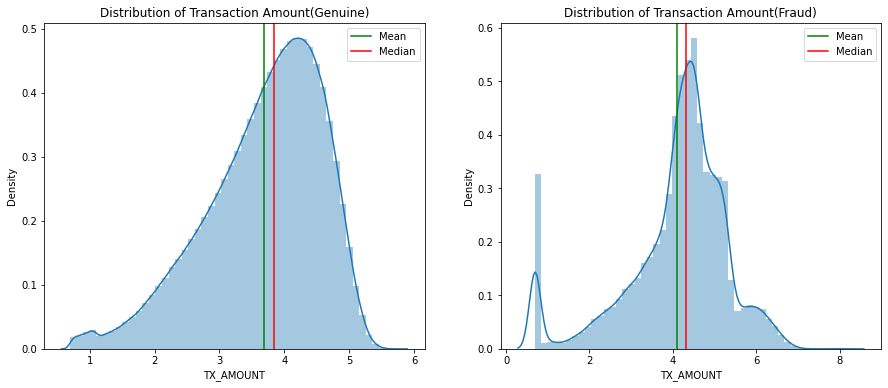

In [ ]:
#summary statistics for TX_Amount of fraud & non fraud

# shape of distribution of non fraud
plt.subplots(1,2, figsize=(15,6))
# distribution using histogram
plt.subplot(1,2,1)
sns.distplot(np.log1p(df_nonfraud['TX_AMOUNT']))
plt.axvline(np.log1p(df_nonfraud['TX_AMOUNT']).mean(), color="g", label="Mean")
plt.axvline(np.log1p(df_nonfraud['TX_AMOUNT']).median(), color="r", label="Median")
plt.legend()
plt.title('Distribution of Transaction Amount(Genuine)')

plt.subplot(1,2,2)
# distribution using histogram for fraud 
sns.distplot(np.log1p(df_fraud['TX_AMOUNT']))
plt.axvline(np.log1p(df_fraud['TX_AMOUNT']).mean(), color="g", label="Mean")
plt.axvline(np.log1p(df_fraud['TX_AMOUNT']).median(), color="r", label="Median")
plt.legend()
plt.title('Distribution of Transaction Amount(Fraud)')

# display plot
plt.show()

**The distribution of genuine transaction amounts follows a Poisson distribution, whereas the distribution of fraudulent transaction amounts shows abnoraml peaks at small amounts, one dollars.**

In [ ]:
# No of terminals involved in fraudulent transactions throughout the year
print('No of terminals', trans.TERMINAL_ID.nunique())
print('No of terminals involved in fraudulent transactions', trans[trans.TX_FRAUD == 1].TERMINAL_ID.nunique())

No of terminals 2500
No of terminals involved in fraudulent transactions 2500


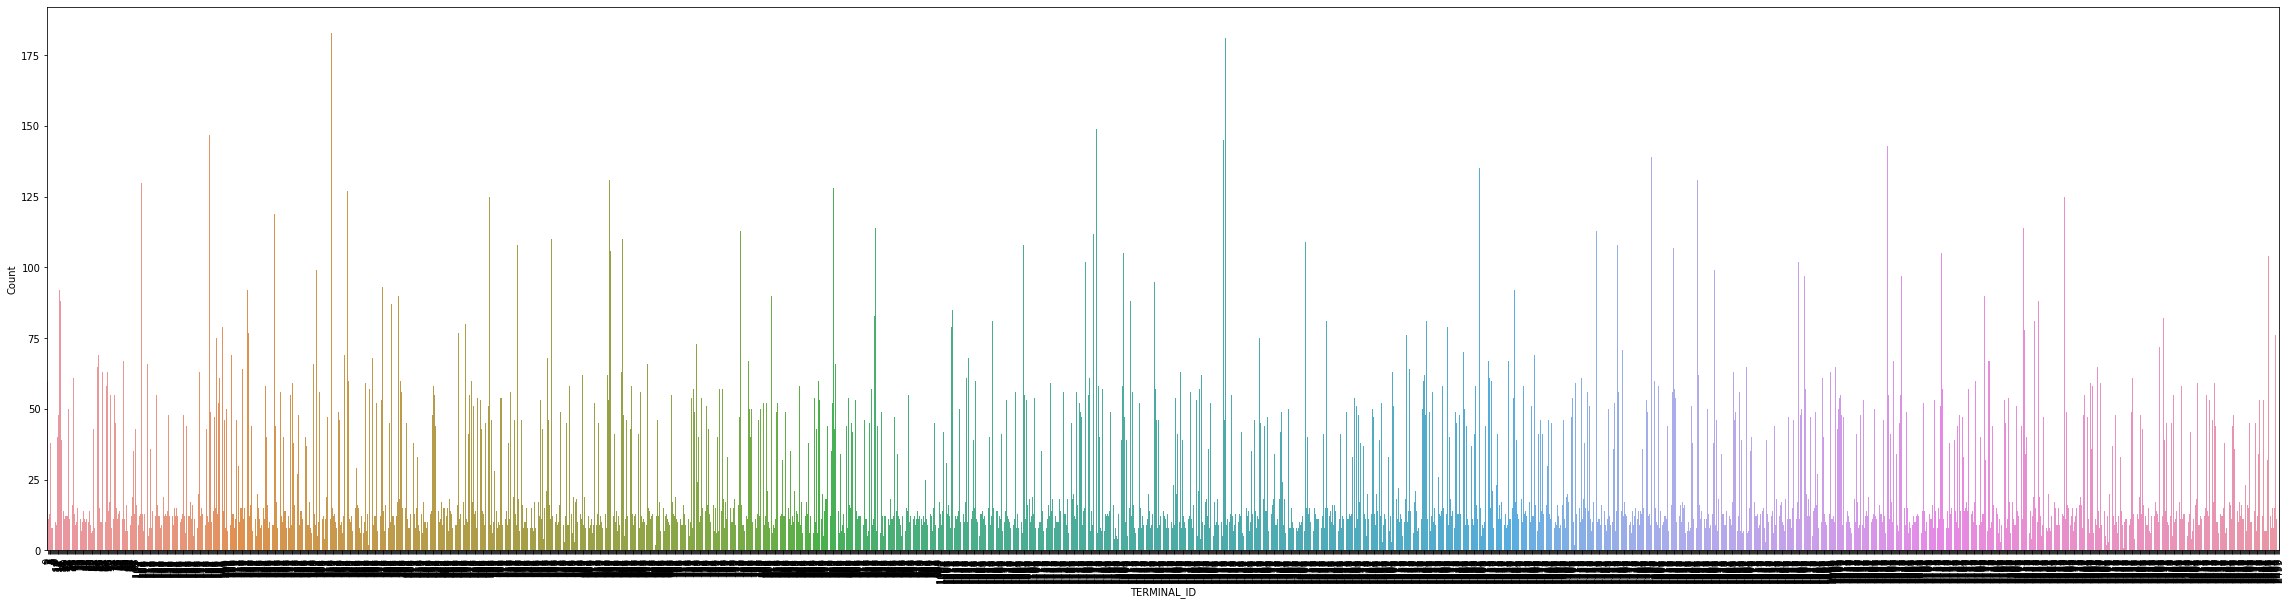

In [ ]:
# No of times each terminal involves in fraudulent transaction
plt.figure(figsize=(40, 10))
ax = sns.barplot(
    data = pd.merge(
        left = term_orig.TERMINAL_ID, 
        right = trans[trans.TX_FRAUD == 1].groupby('TERMINAL_ID').size().rename('Count').to_frame(), 
        left_on = 'TERMINAL_ID', 
        right_on = 'TERMINAL_ID', 
        how = 'left'),
    x = 'TERMINAL_ID',
    y = 'Count' )
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()
## INSIGHT:
## Any terminal can be used for fraudulent transaction
## Some terminals are being used for fraudulent transaction much more than others

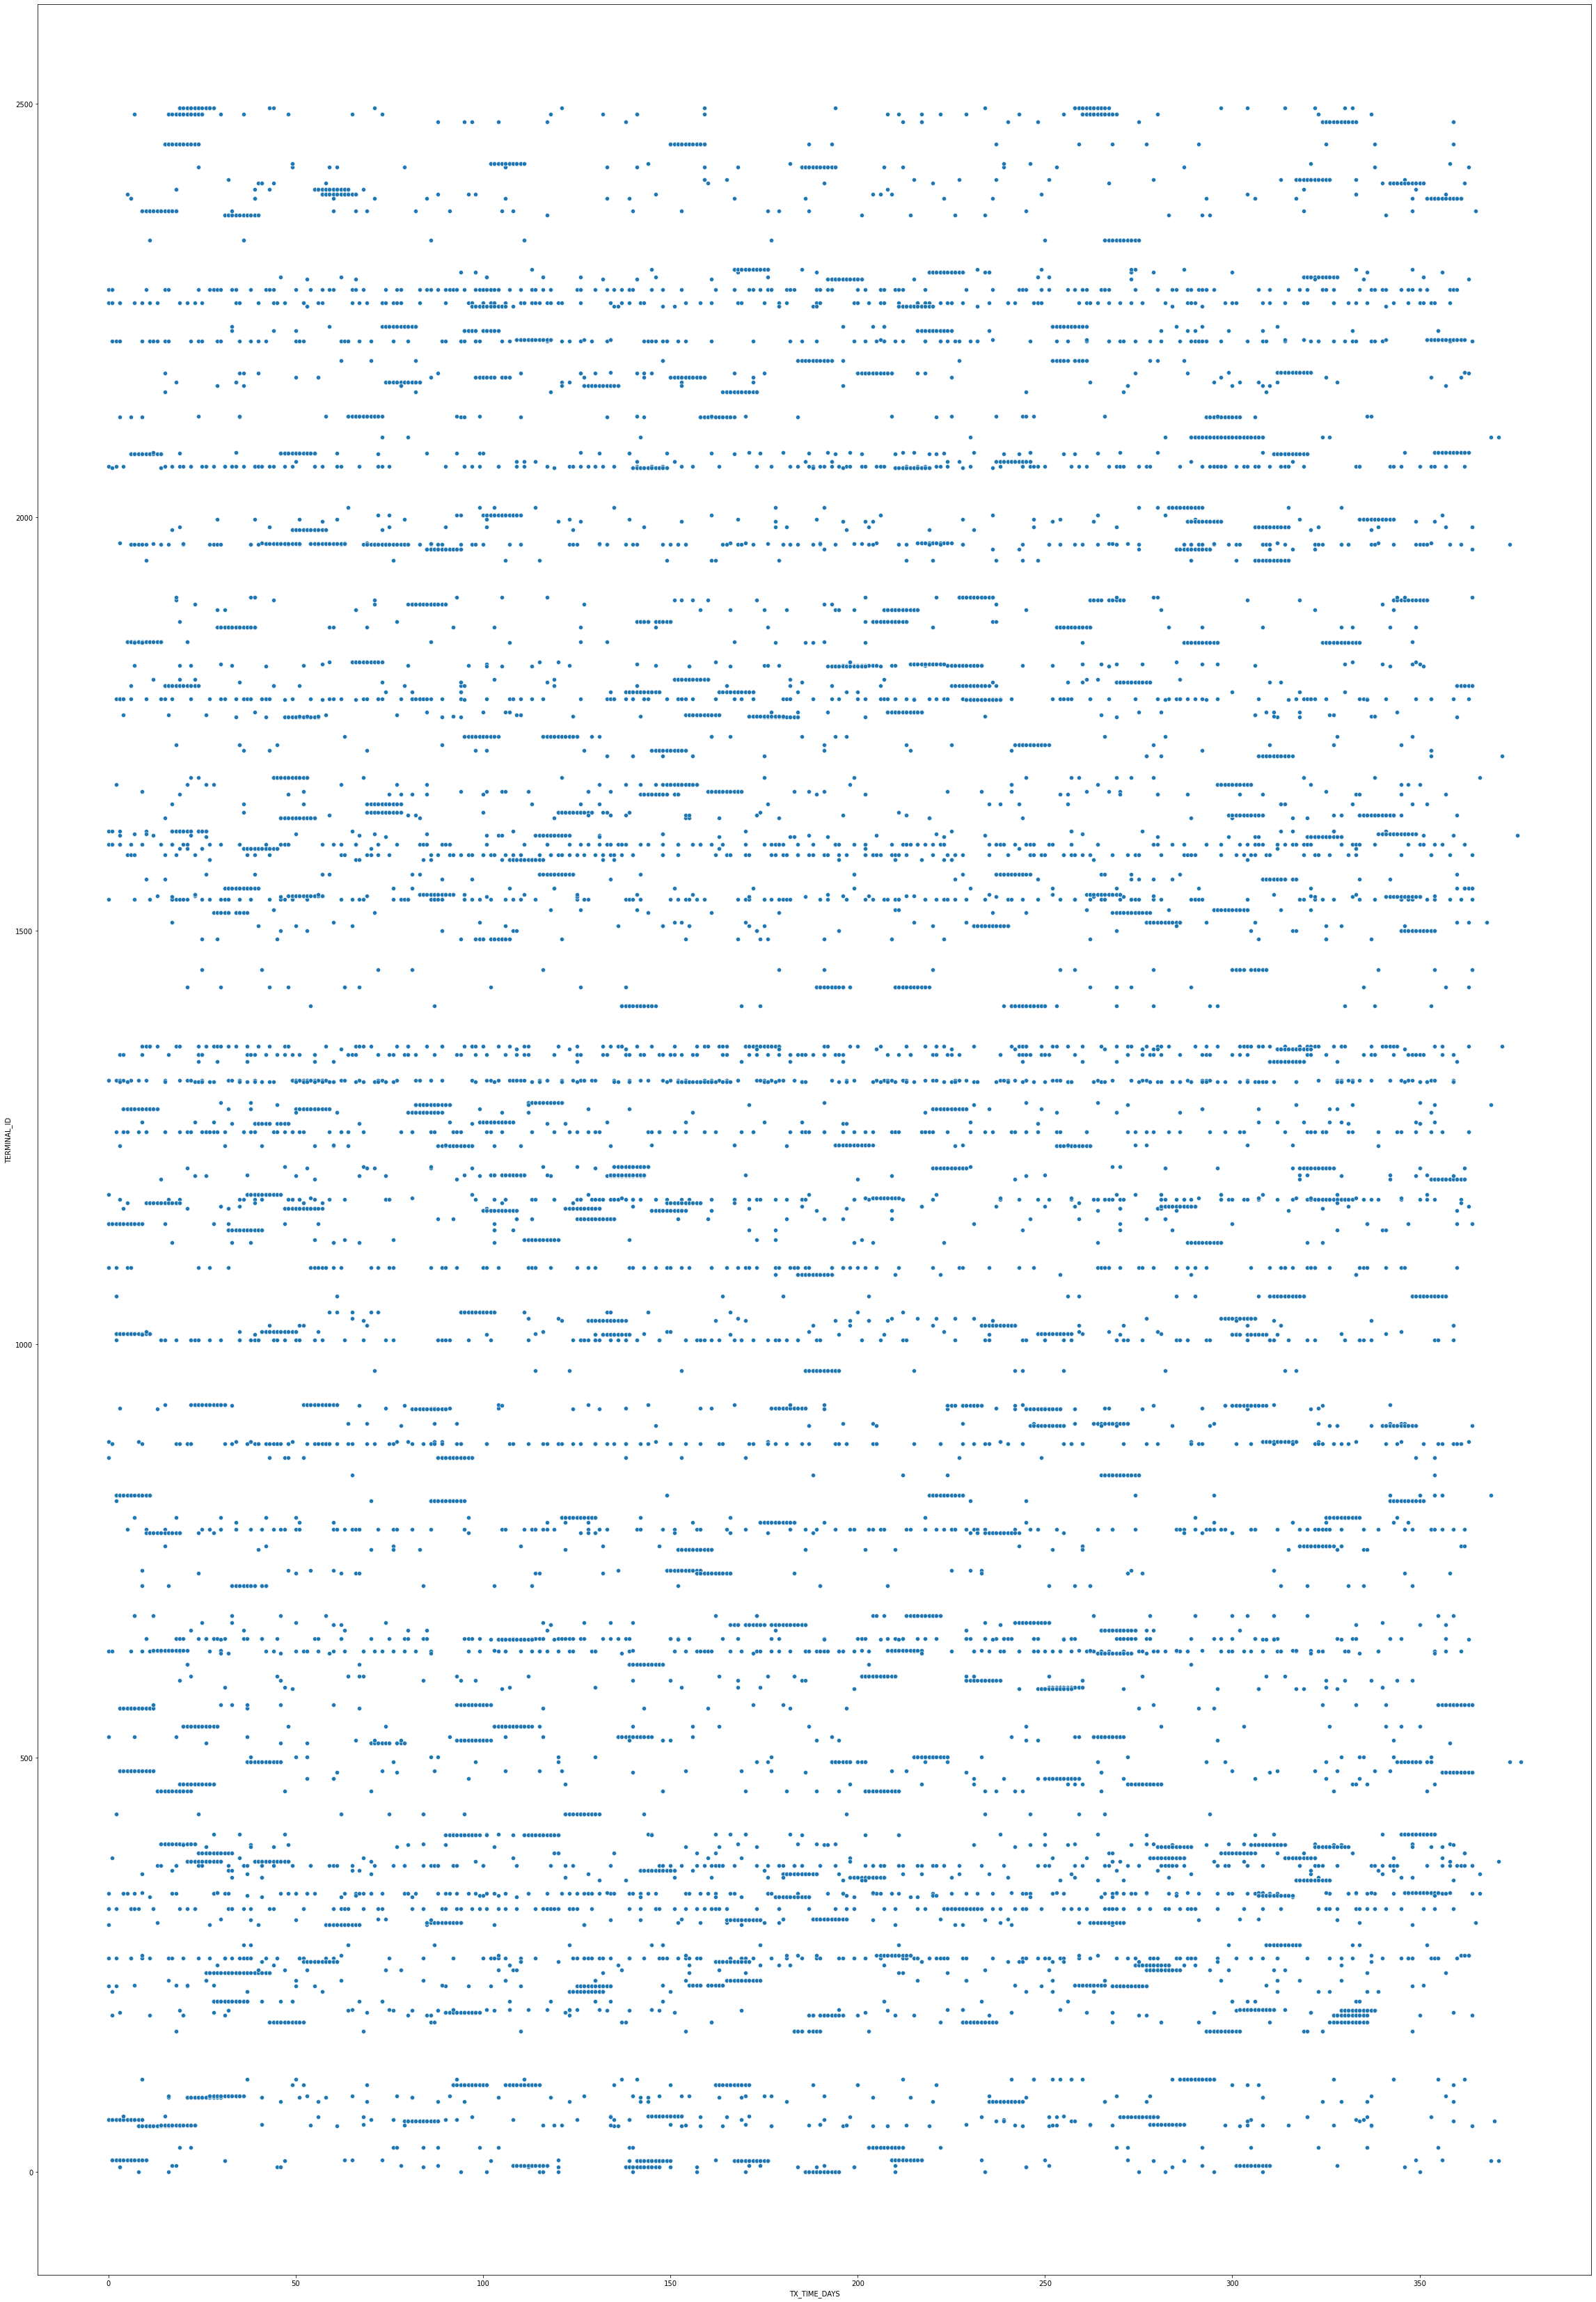

In [ ]:
# Days of top 10% terminal involved in fraudulent transactions plotted against time
# 
df = trans[trans.TX_FRAUD == 1]
df = pd.merge(left = df, right = df.groupby('TERMINAL_ID').size().rank(pct = True).rename('percentile'), on = 'TERMINAL_ID')

plt.figure(figsize=(40,60))
_ = sns.scatterplot(data = df[(df.percentile > 0.9)], x = 'TX_TIME_DAYS', y = 'TERMINAL_ID')
## INSIGHT: 
## Terminals often being used for fraud transaction for consecutive days

# **There are three fraud transaction occurences pattern.** (Tableau visualisation)

1. **Sporadic** :fraud transaction occur irregularly at different terminal, like terminal 319 here 

2. **Cluster** : fraud transaction occur for  a consecutive period of time at different terminal, like terminal 326

3. **Consistent** : fraud transaction occur consistently  at the same terminal for a long period of time, like terminal 336


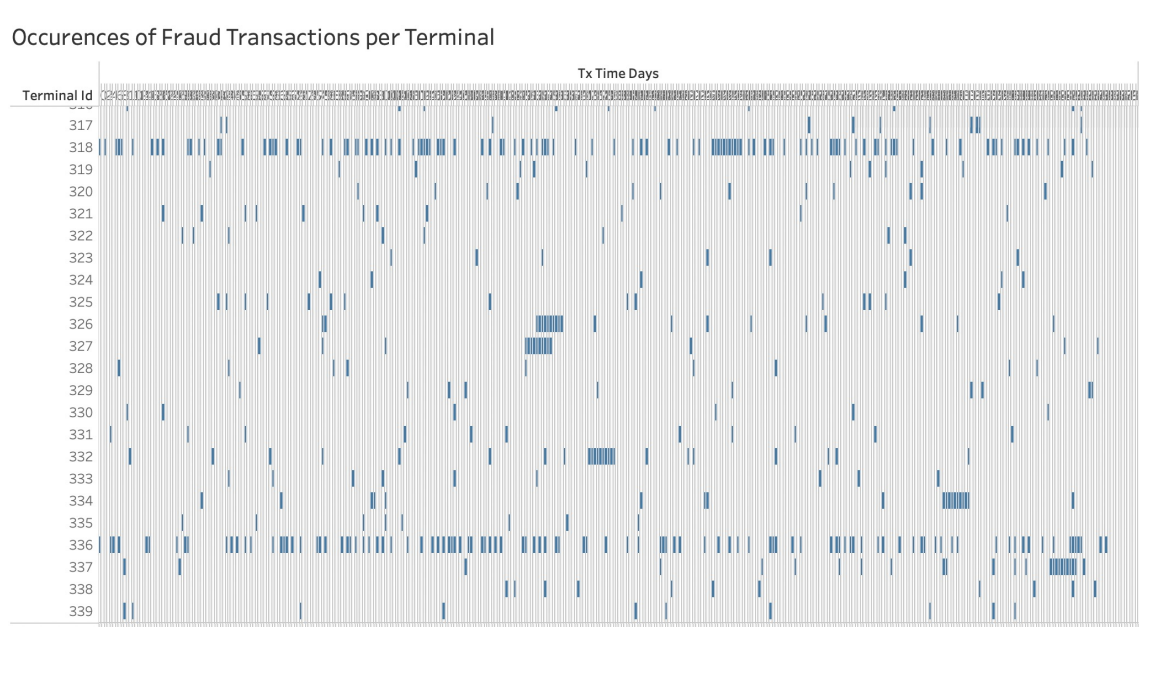

**The distribution of genuine transaction amounts follows a Poisson distribution, whereas the distribution of fraudulent transaction amounts shows abnoraml peaks at small amounts, one dollars.**

It is assumed that some terminal are comprised, calculating the distance of customer to terminal for fraud and geunine transaction may identify possible comprised terminl

In [ ]:
df = pd.merge(left = trans[['TRANSACTION_ID', 'CUSTOMER_ID','TERMINAL_ID','TX_FRAUD']], right = cust_orig[['CUSTOMER_ID', 'x_customer_id', 'y_customer_id']], on = 'CUSTOMER_ID', how = 'inner')
df = pd.merge(left = df, right = term_orig[['TERMINAL_ID', 'x_terminal_id', 'y_terminal_id']], on = 'TERMINAL_ID', how = 'inner')
df.apply(lambda r : math.dist( (r.x_customer_id,r.y_customer_id), (r.x_terminal_id,r.y_terminal_id) ), axis = 1 )

C:\Users\DS\Applications\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\DS\Applications\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


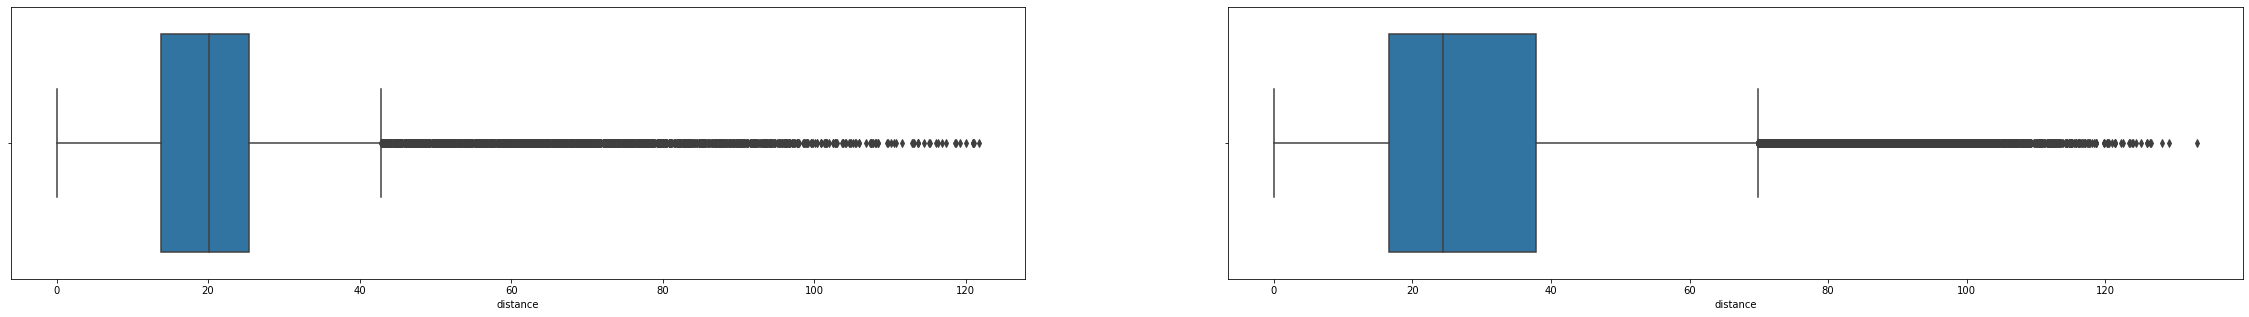

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(40,5))
_ = sns.boxplot(df[df.TX_FRAUD == 0]['distance'], ax = axes[0])
_ = sns.boxplot(df[df.TX_FRAUD == 1]['distance'], ax = axes[1])

In [ ]:
print('Customer-terminal distance variance of Genuine transactions', df[df.TX_FRAUD == 0].var().distance)
print('Customer-terminal distance variance of Fraudulent transactions', df[df.TX_FRAUD == 1].var().distance)

Customer-terminal distance variance of Genuine transactions 54.66278491340398
Customer-terminal distance variance of Fraudulent transactions 511.73074013315716
